Success analysis : finding cofounders 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np
import string

In [2]:
character_metadata = pd.read_csv('Data/character.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_release_date',
                                                                              'Character_name',
                                                                              'Actor_date_of_birth',
                                                                              'Actor_gender',
                                                                              'Actor_height',
                                                                              'Actor_ethnicity',
                                                                              'Actor_name',
                                                                              'Actor_age_at_movie_release',
                                                                              'Freebase_character/actor_map_ID',
                                                                              'Freebase_character_ID',
                                                                              'Freebase_actor_ID'])

movie_metadata = pd.read_csv('Data/movie.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_name',
                                                                              'Movie_release_date',
                                                                              'Movie_box_office_revenue',
                                                                              'Movie_runtime',
                                                                              'Movie_languages',
                                                                              'Movie_countries',
                                                                              'Movie_genres'])

plot_summaries = pd.read_csv('Data/plot_summaries.txt', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'summary'])

In [7]:
# Take inflation in account 

cpi = pd.read_csv('Data/CPI.csv', sep=';')

def adjust_inflation(revenue, year):
    consumer_price_index = cpi['Annual'][cpi['Year'] == year]
    revenue_adjusted = revenue * (consumer_price_index / cpi['Annual'].iloc[0])
    return revenue_adjusted

movie_metadata['Box_office_adjusted'] = movie_metadata.apply(lambda row : adjust_inflation(row['Movie_box_office_revenue'], row['Movie_release_date']), axis=1)


ValueError: Cannot set a DataFrame with multiple columns to the single column Box_office_adjusted

In [3]:
# Load IMDB ratings

ratings_imdb = pd.read_table('Data/ratings_imdb.tsv', sep="\t")
ratings_imdb.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2005
1,tt0000002,5.8,269
2,tt0000003,6.5,1908
3,tt0000004,5.5,178
4,tt0000005,6.2,2688


In [15]:
# import the file with the movies titles ID from imdb
import gdown
import pandas as pd

link_drive = "https://drive.google.com/file/d/1ZkAQhufH1q1a9aJDgs_AzR0hoo2p-LWQ/view?usp=share_link"
id_fichier = link_drive.split("/")[-2]
link_direct = f"https://drive.google.com/uc?id={id_fichier}"
name_file_local = "titles_imdb.tsv"
gdown.download(link_direct, name_file_local, quiet=False)
movie_imdb = pd.read_csv(name_file_local, sep='\t')

unuseful = ['titleType', 'isAdult', 'endYear', 'genres']
movie_imdb.drop(unuseful, axis =1, inplace=True)
movie_imdb.head()


Downloading...
From (uriginal): https://drive.google.com/uc?id=1ZkAQhufH1q1a9aJDgs_AzR0hoo2p-LWQ
From (redirected): https://drive.google.com/uc?id=1ZkAQhufH1q1a9aJDgs_AzR0hoo2p-LWQ&confirm=t&uuid=3b50d0ea-8039-4164-bda4-d77d1feff727
To: /Users/blanchekerorgant/Documents/GitHub/2023/2023/ada-2023-project-randada/Projet/titles_imdb.tsv
100%|██████████| 884M/884M [01:26<00:00, 10.2MB/s] 
/var/folders/tn/v_tw25wx0cxgctjg5n0dqd0w0000gn/T/ipykernel_32712/1716720349.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_imdb = pd.read_csv(name_file_local, sep='\t')


,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes
0,tt0000001,Carmencita,Carmencita,1894,1
1,tt0000002,Le clown et ses chiens,Le clown et ses chiens,1892,5
2,tt0000003,Pauvre Pierrot,Pauvre Pierrot,1892,4
3,tt0000004,Un bon bock,Un bon bock,1892,12
4,tt0000005,Blacksmith Scene,Blacksmith Scene,1893,1


In [28]:
# Load budget info about imdb movies

budget = pd.read_csv('Data/imdb_budget.csv',sep=",")
budget['date_x']=budget['date_x'].str.strip()
budget['date_x'] = pd.to_datetime(budget['date_x'], format='%m/%d/%Y')
budget['Year'] = budget['date_x'].dt.year
unuseful = ['overview', 'status', 'crew', 'orig_lang', 'country', 'score', 'genre', 'orig_title', 'date_x']
budget.drop(unuseful, axis =1, inplace=True)
budget.sample(10)

,names,budget_x,revenue,Year
6462,The Secret of Moonacre,32000000.0,7162618.0,2009
837,Scream 3,40000000.0,161838076.0,2000
98,The Woman King,50000000.0,94374749.0,2022
254,Paradise City,20000000.0,161597374.4,2023
5648,Mutant Pumpkins from Outer Space,105000000.0,718845506.2,2009
9755,Trash,12000000.0,6553186.0,2015
5085,The Way of the Dragon,130000.0,27000000.0,1972
5124,The Ten Commandments,10000000.0,1051907.0,2007
6028,Amy,25255933.2,8413144.0,2015
4955,Bullitt,5500000.0,42300873.0,1985


In [6]:
# Load Rotten tomatoes dataset

rotten_tomatoes = pd.read_table('Data/movies_rottentomatoes.csv', sep=",")
rotten_tomatoes.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [16]:
#load the dataset with the list of famous actors (top 100 from IMDB) 

famous_actors= pd.read_csv('Data/famous_actors.csv')

movies = pd.read_csv('Data/movies_metadata_english_only.csv')
famous_actors.head()
unuseful = ['Description', 'Birth Date', 'Created', 'Modified', 'Known For', 'Position']
famous_actors.drop(unuseful, axis =1, inplace=True)
famous_actors.head()


,Const,Name
0,nm0000134,Robert De Niro
1,nm0000197,Jack Nicholson
2,nm0000008,Marlon Brando
3,nm0000243,Denzel Washington
4,nm0000031,Katharine Hepburn


In [17]:
#clean the movie dataset from imdb

movie_imdb['startYear'] = movie_imdb['startYear'].replace('\\N', np.nan)
movie_imdb['runtimeMinutes'] = movie_imdb['runtimeMinutes'].replace('\\N', np.nan)

movie_imdb.dropna(subset=['startYear'], inplace =True)
movie_imdb.dropna(subset=['runtimeMinutes'], inplace =True)

movie_imdb['startYear']=movie_imdb['startYear'].astype('int')
movie_imdb['runtimeMinutes']=movie_imdb['runtimeMinutes'].astype(int).astype('int')

In [18]:
# merging imdb movies dataset and CMU movies dataset on Movie title, release date and runtime 

merged_movies = movies.merge(movie_imdb,left_on=['Movie_name', 'Movie_release_date', 'Movie_runtime'],right_on=['primaryTitle', 'startYear', 'runtimeMinutes'], how="inner")
print('Size of the new dataset : ', merged_movies.shape)
merged_movies.head()

/var/folders/tn/v_tw25wx0cxgctjg5n0dqd0w0000gn/T/ipykernel_32712/1580238346.py:3: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged_movies = movies.merge(movie_imdb,left_on=['Movie_name', 'Movie_release_date', 'Movie_runtime'],right_on=['primaryTitle', 'startYear', 'runtimeMinutes'], how="inner")


Size of the new dataset :  (13600, 15)


,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",tt0228333,Ghosts of Mars,Ghosts of Mars,2001,98
1,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['English Language'],['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",tt0029852,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106
2,10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,['English Language'],['United States of America'],"['Drama', 'Black-and-white']",tt0021335,Sarah and Son,Sarah and Son,1930,86
3,13,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,['English Language'],['United Kingdom'],"['Costume drama', 'War film', 'Epic', 'Period ...",tt0097499,Henry V,Henry V,1989,137
4,17,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,['English Language'],['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",tt0058331,Mary Poppins,Mary Poppins,1964,139


In [26]:
#adding the ratings feature, merging on tconst

movies_with_ratings= merged_movies.merge(ratings_imdb, left_on='tconst', right_on='tconst', how='inner')
print('Size of the dataset with the ratings : ', movies_with_ratings.shape)
movies_with_ratings.head()

Size of the dataset with the ratings :  (13276, 17)


,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,averageRating,numVotes
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",tt0228333,Ghosts of Mars,Ghosts of Mars,2001,98,4.9,56894
1,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['English Language'],['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",tt0029852,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,6.8,2268
2,10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,['English Language'],['United States of America'],"['Drama', 'Black-and-white']",tt0021335,Sarah and Son,Sarah and Son,1930,86,5.4,299
3,13,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,['English Language'],['United Kingdom'],"['Costume drama', 'War film', 'Epic', 'Period ...",tt0097499,Henry V,Henry V,1989,137,7.5,31193
4,17,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,['English Language'],['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",tt0058331,Mary Poppins,Mary Poppins,1964,139,7.8,181710


In [52]:
#merging with the budget dataset on Movie name and adding the profit column
movies_budget_ratings = movies_with_ratings.merge(budget, left_on='Movie_name', right_on='names', how='inner')
print('Size of the dataset with the ratings : ', movies_budget_ratings.shape)

#movies['budget'] = movies['budget'].astype(float)
#movies['revenue'] = movies['revenue'].astype(float)
movies_budget_ratings['profit'] = movies_budget_ratings['Movie_box_office_revenue'] - movies_budget_ratings['budget_x']
movies_budget_ratings = movies_budget_ratings[movies_budget_ratings['revenue'] > 0]
print(movies_budget_ratings.columns)
print('Size of the dataset with the ratings : ', movies_budget_ratings.shape)

Size of the dataset with the ratings :  (1948, 21)
Index(['Unnamed: 0', 'Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name',
       'Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime',
       'Movie_languages', 'Movie_countries', 'Movie_genres', 'tconst',
       'primaryTitle', 'originalTitle', 'startYear', 'runtimeMinutes',
       'averageRating', 'numVotes', 'names', 'budget_x', 'revenue', 'Year',
       'profit'],
      dtype='object')
Size of the dataset with the ratings :  (1920, 22)


In [48]:
# Standardize the profit and the ratings
print('Size of the dataset with the ratings : ', movies_budget_ratings.shape)
success_data= movies_budget_ratings.copy(deep= True)
print('Size of the dataset with the ratings : ', movies_budget_ratings.shape)

success_data['Movie_box_office_revenue'].dropna(inplace = True)

success_data['profit']= ((success_data['profit']-success_data['profit'].mean())/ success_data['profit'].std())
success_data['averageRating']= (success_data['averageRating']-success_data['averageRating'].mean())/ success_data['averageRating'].std()
print('Size of the dataset with the ratings : ', success_data.shape)

# create an indice for success, based on ratings and box office revenues
success_data["success"]= (success_data['averageRating'] + success_data['profit'])/2

success_data.sample(10)
print(movies_budget_ratings.columns)
# Ne garder que les films avec box office réduit largement le dataset...
#il ya des sucess NaN parce que pas de box office revenue mais 'jarrive pas à les enlever

Size of the dataset with the ratings :  (969, 22)
Size of the dataset with the ratings :  (969, 22)
Size of the dataset with the ratings :  (969, 22)
Index(['Unnamed: 0', 'Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name',
       'Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime',
       'Movie_languages', 'Movie_countries', 'Movie_genres', 'tconst',
       'primaryTitle', 'originalTitle', 'startYear', 'runtimeMinutes',
       'averageRating', 'numVotes', 'names', 'budget_x', 'revenue', 'Year',
       'profit'],
      dtype='object')


In [13]:
# Do famous actors influence the rating ?

#merge movies and character metadata to have access to actors information per movie
movies_and_actors = success_data.merge(character_metadata,on='Wikipedia_movie_ID',how='inner')

#to be considered as famous, an actor has to be in the famous_actors dataset
movies_and_actors['IsFamousActor']=movies_and_actors['Actor_name'].isin(famous_actors['Name'])

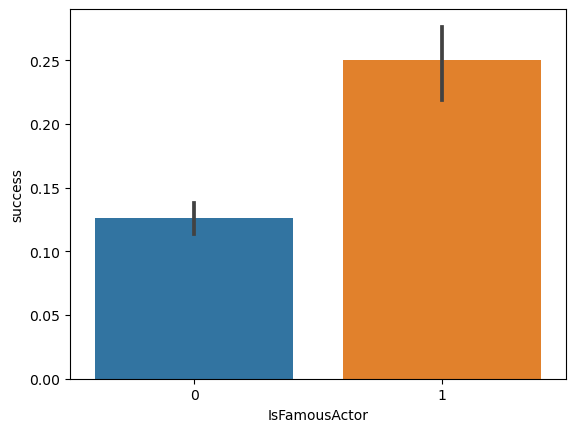

In [14]:
movies_and_actors['IsFamousActor'] = movies_and_actors['IsFamousActor'].astype(int)
ax = sns.barplot(data=movies_and_actors, x=movies_and_actors['IsFamousActor'],y=movies_and_actors['success'])

#est-ce qu'on garde que les films avec un revenue pour l'analyse du succès ? ça réduit beaucoup le dataframe non ? et est-ce qu'on ajuste avec l'inflation ?

In [ ]:
# Load the inflation dataset of the consumer price indices between 1914 and 2023 from OECD
inflation = pd.read_csv('Data/inflation_cpi.csv')
